# Domain Error Data Analysis
In this notebook, I will find out the best python modules to read in Domain data and carry out an exploratory analysis to understand problem.

## Shapefiles
The shape files can be read in via shapefile (installed as pyshp)

In [1]:
import shapefile

In [2]:
sf = shapefile.Reader('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/NOR_9_1_Domain.shp')


In [3]:
sf.shapes()[0].points[0]

(412706.3804254929, 621365.3729263357)

In [4]:
import matplotlib
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
patches=[Polygon(sf.shapes()[0].points, True)]


(620500.0, 622500.0000000019)

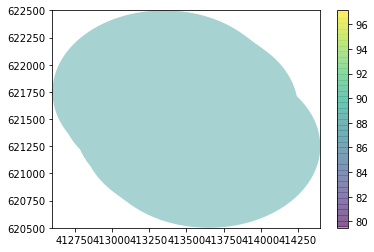

In [6]:
fig, ax = plt.subplots()

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
lims=sf.shapes()[0].bbox
plt.xlim(lims[0],lims[2])
plt.ylim(lims[1],lims[3])

## Flood sims
The Flood sims are tif files and can be read in via gdal

In [7]:
import gdal

In [8]:
floodmap=gdal.Open('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/CombinedOutput_FloodMap/NOR_Fluvial_100yr.tif')

In [9]:
arr = floodmap.ReadAsArray()

## Plotting the two
Requires consistant frame. Geospatial information should be in tif file. Nice example @ [http://alimanfoo.github.io/2016/10/04/plotting-african-ecosystems.html](http://alimanfoo.github.io/2016/10/04/plotting-african-ecosystems.html)

In [10]:
proj_wkt = floodmap.GetProjection()
print(proj_wkt)


PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [11]:
from osgeo import osr

In [12]:
proj = osr.SpatialReference()
proj.ImportFromWkt(proj_wkt)
print(proj)


PROJCS["British_National_Grid",
    GEOGCS["GCS_OSGB_1936",
        DATUM["OSGB_1936",
            SPHEROID["Airy_1830",6377563.396,299.3249646,
                AUTHORITY["EPSG","7001"]],
            AUTHORITY["EPSG","6277"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",49],
    PARAMETER["central_meridian",-2],
    PARAMETER["scale_factor",0.9996012717],
    PARAMETER["false_easting",400000],
    PARAMETER["false_northing",-100000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]


In [13]:
geo_transform = floodmap.GetGeoTransform()

In [14]:
geo_transform

(356390.0001220703, 5.0, 0.0, 647200.0001220703, 0.0, -5.0)

In [15]:
origin_x = geo_transform[0]
origin_y = geo_transform[3]
pixel_width = geo_transform[1]
pixel_height = geo_transform[5]
n_cols = floodmap.RasterXSize
n_rows = floodmap.RasterYSize
n_cols, n_rows

(23712, 29062)

In [16]:
band = floodmap.GetRasterBand(1)
gdal.GetDataTypeName(band.DataType)

'Float32'

In [17]:
import humanize
humanize.naturalsize(n_cols * n_rows * 4)

'2.8 GB'

In [18]:
band.GetMinimum()

1.4901161193848e-08

In [19]:
band.GetColorTable() is None

True

In [20]:
extent_lonlat = (
    origin_x, 
    origin_x + (pixel_width * floodmap.RasterXSize),
    origin_y + (pixel_height * floodmap.RasterYSize),
    origin_y
)

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


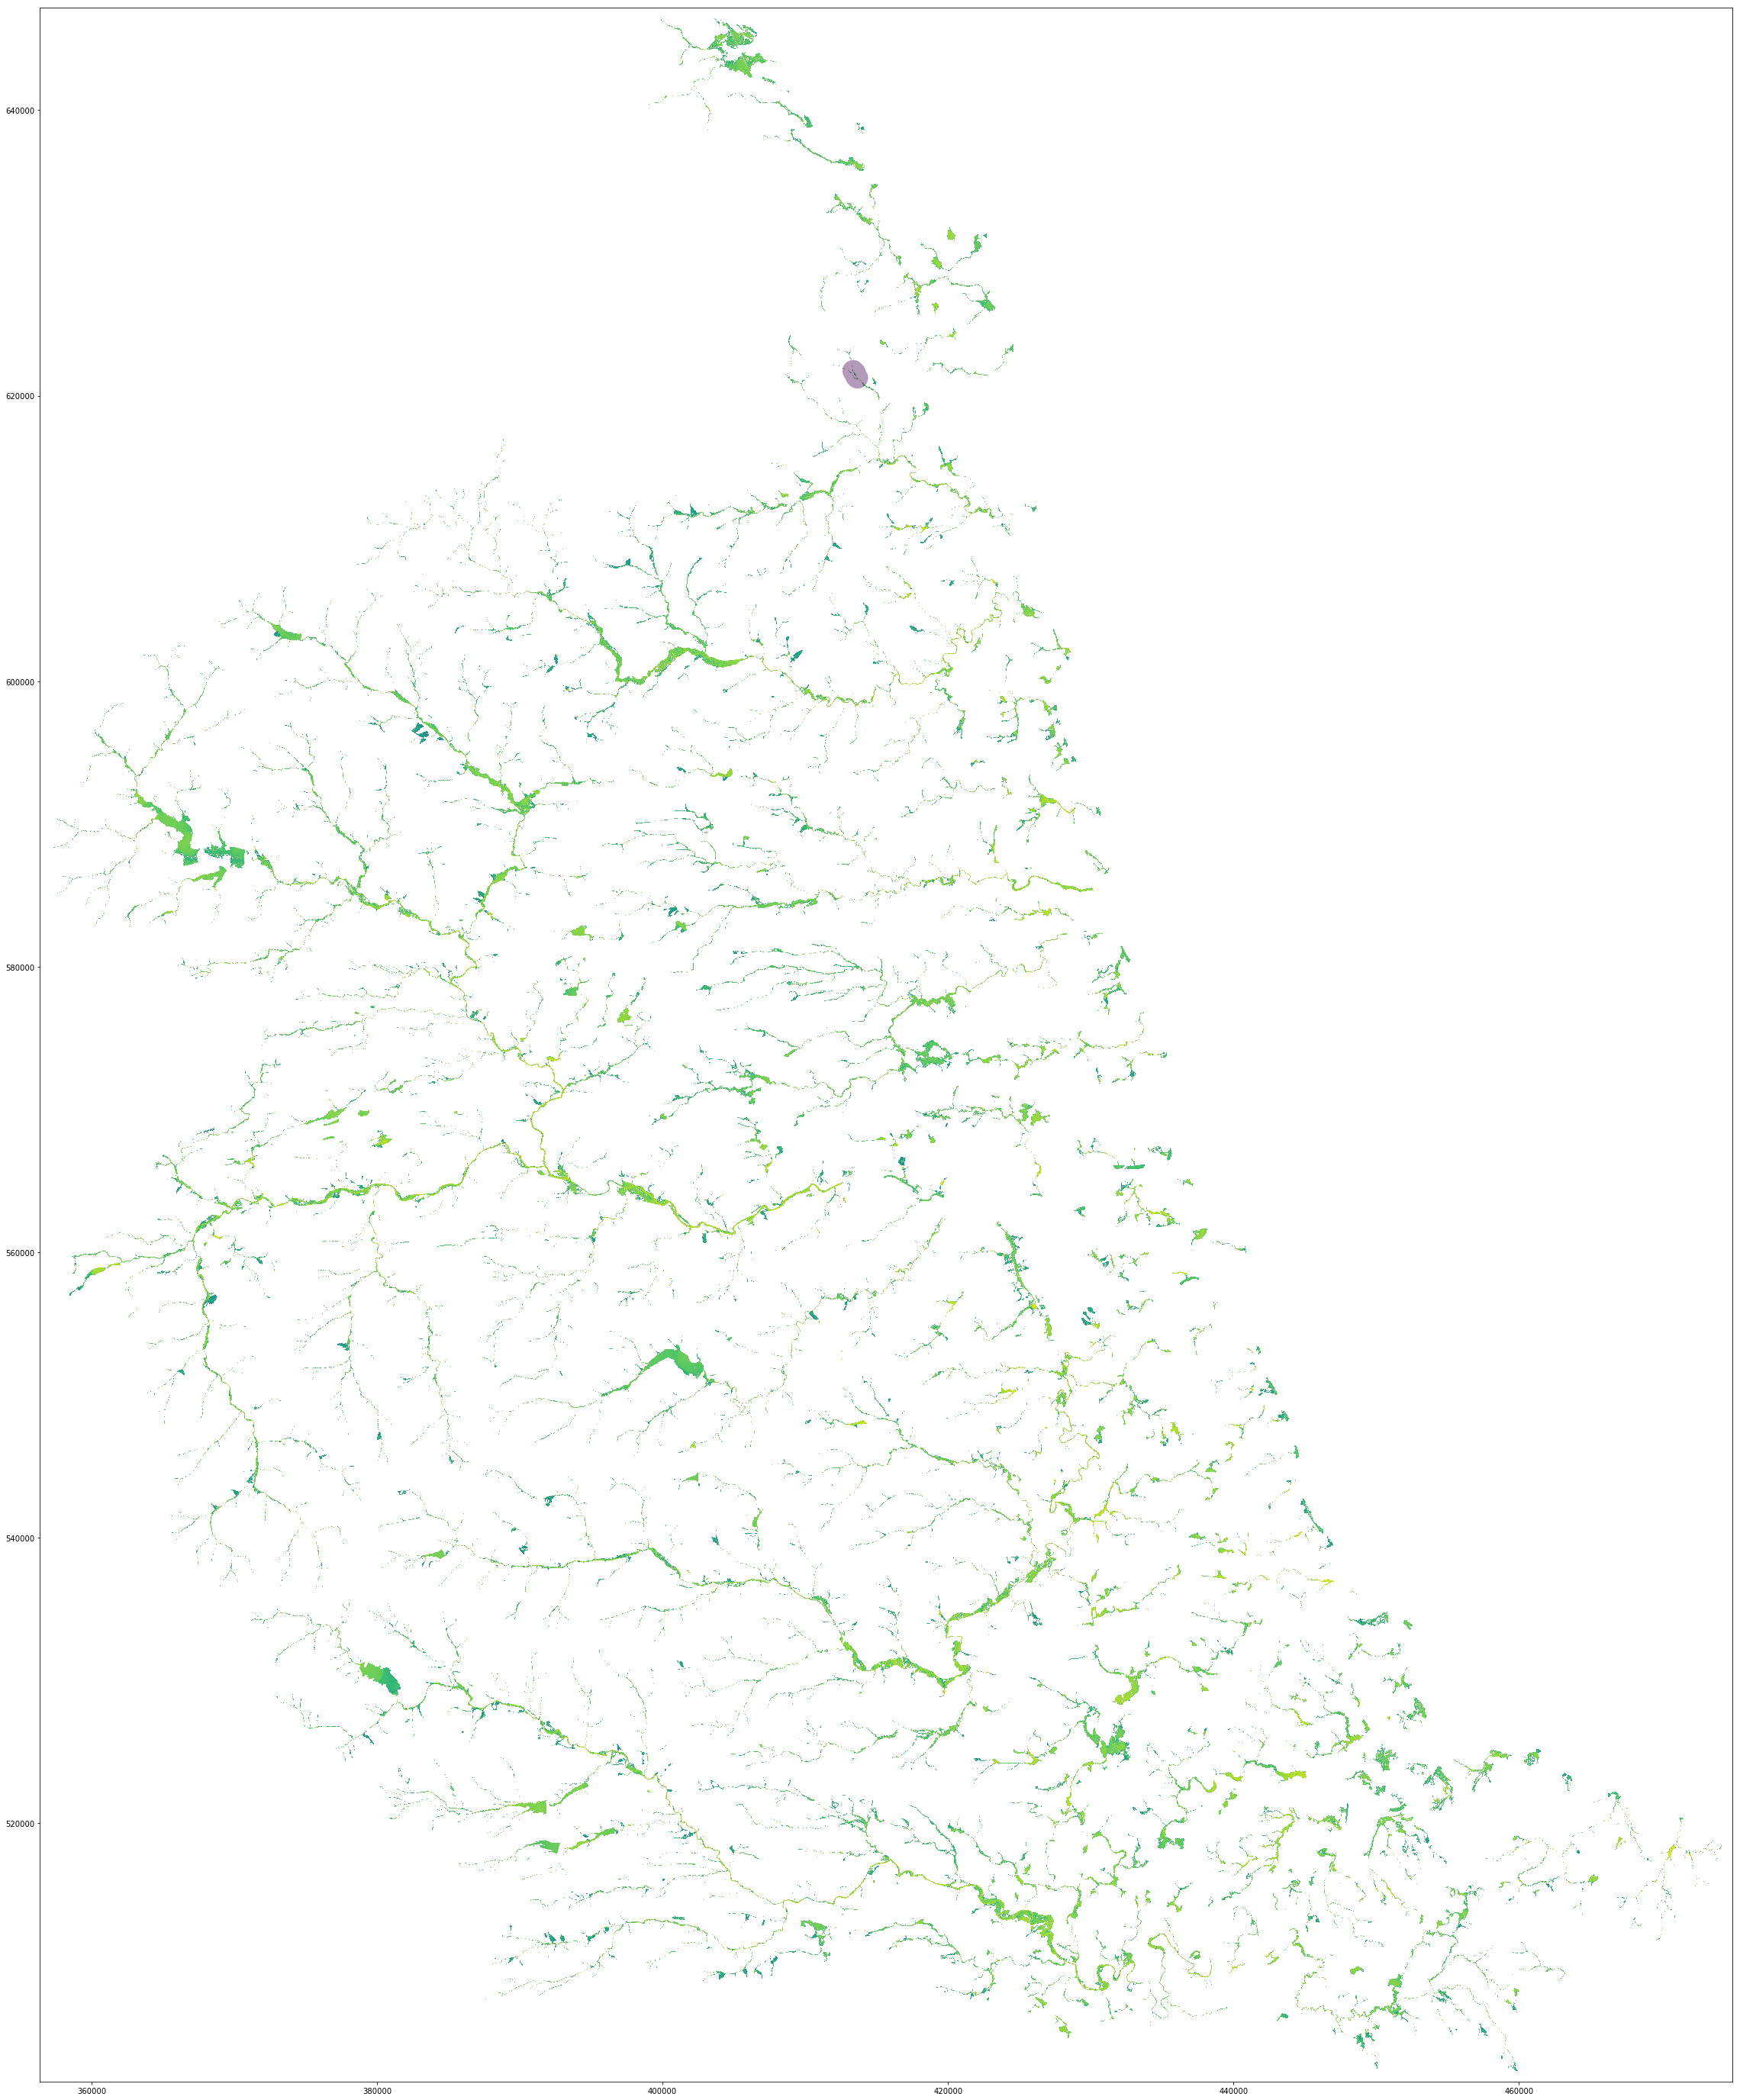

In [29]:

fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(np.log10(arr), vmin=np.log10(band.GetMinimum()), vmax=np.log10(band.GetMaximum()), cmap='viridis', extent=extent_lonlat)
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)


## Ideas
1. create bluured outline from raster image, create blurred outline from shapefile, look at residual. Where residual is low there is correlation
2. cross correlate shape file with image. Correlation likely when curveture of floodmap is same as curvature of shapefile
3. Scan around shapefile. Plot pixel difference across boundary

## Examples of Domain errors
We have been give a full sim output and domain shapefiles. We don't know where there are problems without checking by eye.


## Idea 3
* Read in shapefile
* Match points and tangent to image
* plot difference across boundary

In [83]:
import shapefile
sf = shapefile.Reader('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/NOR_5072_1_Domain.shp')


In [84]:
sh_points=np.array(sf.shapes()[0].points)

In [85]:
sh_points.shape

(151, 2)

In [86]:
xpix=np.arange(extent_lonlat[0],extent_lonlat[1],pixel_width)
ypix=np.arange(extent_lonlat[3],extent_lonlat[2],pixel_height)

In [87]:
def find_nearest(array, value):
    ''' Find nearest value is an array '''
    idx = (np.abs(array-value)).argmin()
    return idx

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


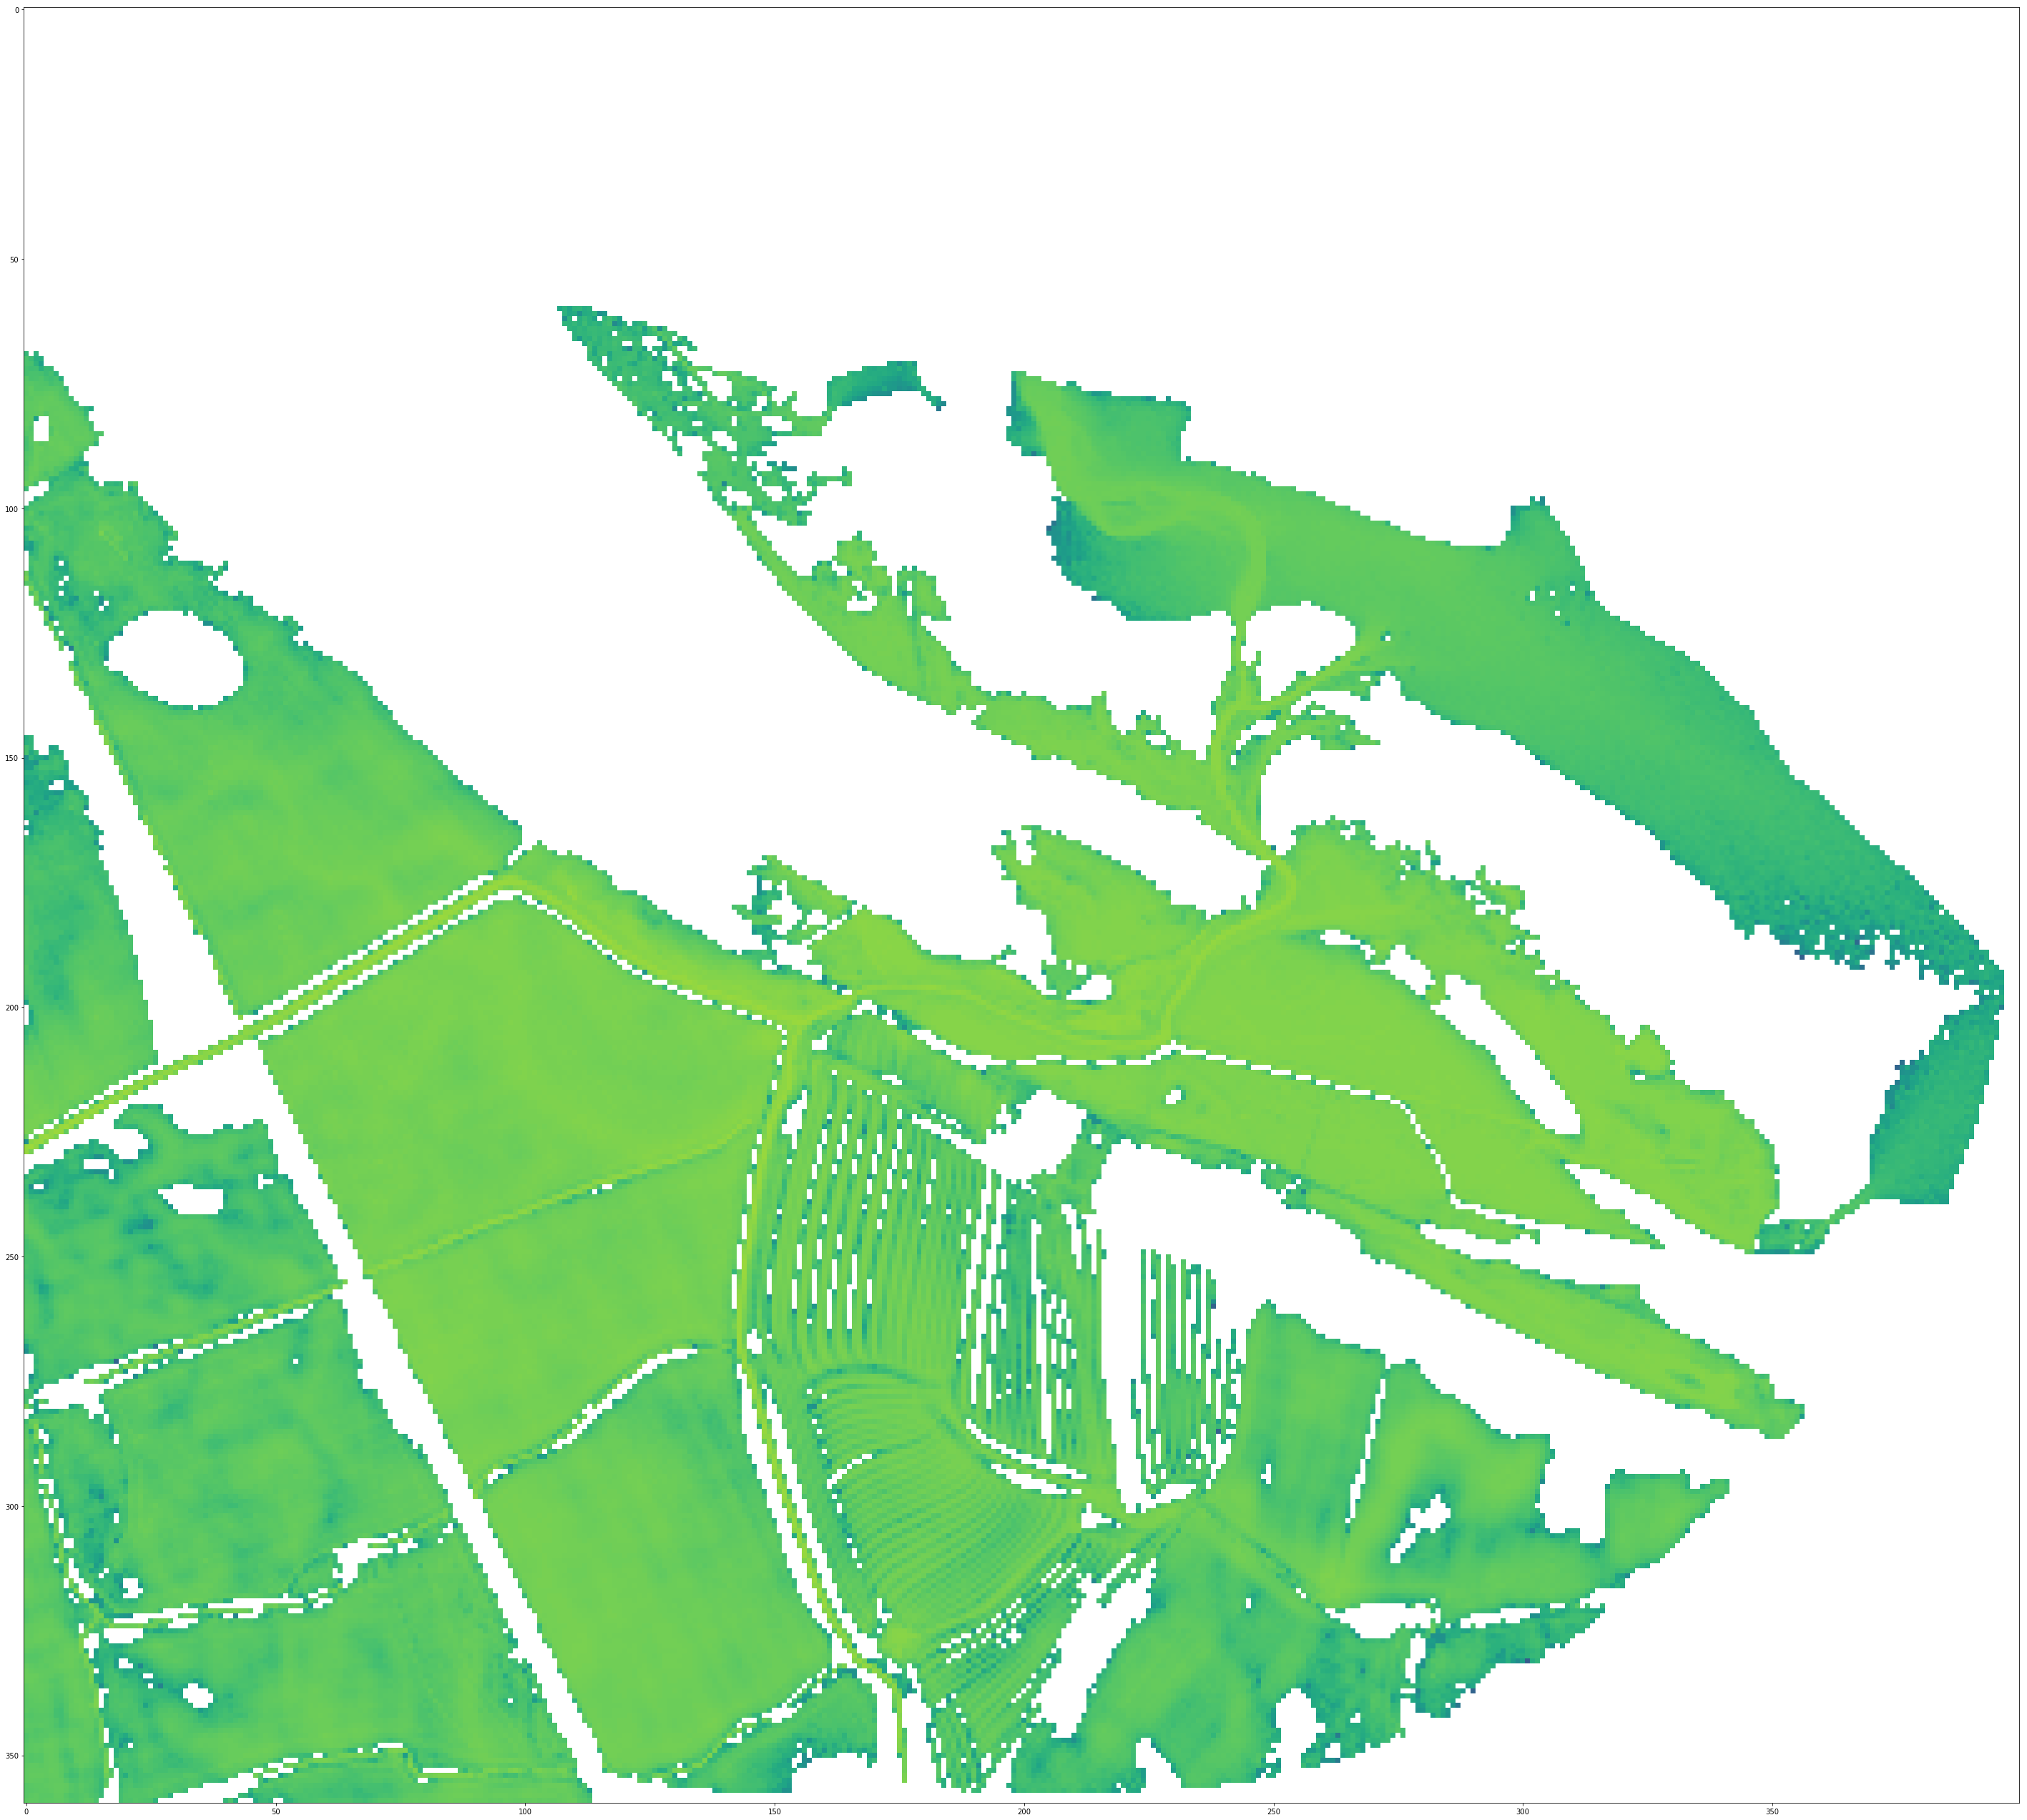

In [88]:
plt.figure(figsize=(50,50))
xmin=find_nearest(xpix,np.min(sh_points[:,0]))
xmax=find_nearest(xpix,np.max(sh_points[:,0]))
ymin=find_nearest(ypix,np.min(sh_points[:,1]))
ymax=find_nearest(ypix,np.max(sh_points[:,1]))
plt.imshow(np.log10(arr[ymax:ymin,xmin:xmax]),vmin=np.log10(band.GetMinimum()), vmax=np.log10(band.GetMaximum()), cmap='viridis')


In [89]:
# loop over shape points
val=np.empty((9,sh_points.shape[0]-1))
for i in range(0,sh_points.shape[0]-1):
    #get vals on boundary of shapefile
    x=find_nearest(xpix,sh_points[i,0])
    y=find_nearest(ypix,sh_points[i,1])
    val[0,i]=arr[y,x]
    val[1,i]=x
    val[2,i]=y

    #get vals across boundary
    if i<sh_points.shape[0]-1:
        #calculate difference in x and y for tangent
        dy=sh_points[i+1,1]-sh_points[i,1]
        dx=sh_points[i+1,0]-sh_points[i,0]
        angle=0.5*np.pi-np.arctan(dy/dx)
        pix_dist=4
        t_x=pix_dist*pixel_width*np.cos(angle)#ideally should be 0.5*pixel but more stable if 1.1
        t_y=pix_dist*pixel_height*np.sin(angle)
        #inner value
        x=find_nearest(xpix,sh_points[i,0]+t_x)
        y=find_nearest(ypix,sh_points[i,1]+t_y)
        val[3,i]=arr[y,x]
        val[4,i]=x
        val[5,i]=y
        #outer value
        x=find_nearest(xpix,sh_points[i,0]-t_x)
        y=find_nearest(ypix,sh_points[i,1]-t_y)
        val[6,i]=arr[y,x]
        val[7,i]=x
        val[8,i]=y

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


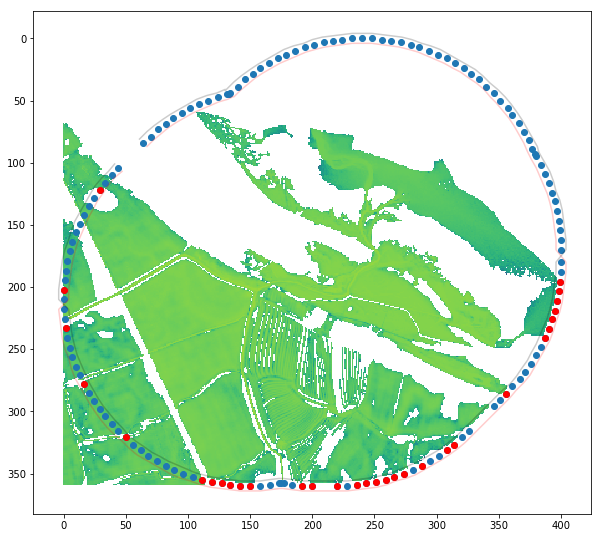

In [90]:
plt.figure(figsize=(10,10))
plt.imshow(np.log10(arr[ymax:ymin,xmin:xmax]),vmin=np.log10(band.GetMinimum()), vmax=np.log10(band.GetMaximum()), cmap='viridis')
ind=val[0,:]<100
#ind=[0,1]
plt.plot(val[1,ind]-xmin,val[2,ind]-ymax, 'o')
plt.plot(val[4,ind]-xmin,val[5,ind]-ymax, 'r-', alpha=0.2)
plt.plot(val[7,ind]-xmin,val[8,ind]-ymax, 'k-', alpha=0.2)
#plt.xlim(7320.-xmin,  7340.-xmin)
#plt.ylim(16440.-ymax,  16420.-ymax)
ind=np.abs(val[3,:]-val[6,:])>100
plt.plot(val[1,ind]-xmin,val[2,ind]-ymax, 'ro')


In [107]:
from scipy import interpolate
# loop over shape points
val=np.empty((9,sh_points.shape[0]-1))
inner=[]
outer=[]
pix_dist=5

for i in range(0,sh_points.shape[0]-1):
    #get vals on boundary of shapefile
    x=find_nearest(xpix,sh_points[i,0])
    y=find_nearest(ypix,sh_points[i,1])
    val[0,i]=arr[y,x]
    val[1,i]=x
    val[2,i]=y
    #need to interpolate between points in shapefile
    fx = interpolate.interp1d(sh_points[i:i+2,0],sh_points[i:i+2,1],kind='slinear',fill_value='extrapolate')
    if sh_points[i,0]<sh_points[i+1,0]:
        xnew=np.arange(sh_points[i,0],sh_points[i+1,0],pixel_width)
    else:
        xnew=np.arange(sh_points[i,0],sh_points[i+1,0],-pixel_width)
    ynew=fx(xnew)
    fy=interpolate.interp1d(sh_points[i:i+2,1],sh_points[i:i+2,0],kind='slinear',fill_value='extrapolate')
    if sh_points[i,1]>sh_points[i+1,1]:
        ynew_2=np.arange(sh_points[i,1],sh_points[i+1,1],pixel_height)
    else:
        ynew_2=np.arange(sh_points[i,1],sh_points[i+1,1],-pixel_height)
    xnew_2=fy(ynew_2)
    #get vals across boundary
    #val[3,i]=xnew.shape[0]
    #val[4,i]=xnew_2.shape[0]
    
    if (xnew.shape[0]==0) & (xnew_2.shape[0]==0):
        print(i,xnew,ynew,xnew_2,ynew_2,sh_points[i:i+2,0],sh_points[i:i+2,1])
        
        
    for j in range(xnew.shape[0]-1):
        #calculate difference in x and y for tangent
        dy=ynew[j+1]-ynew[j]
        dx=xnew[j+1]-xnew[j]
        angle=0.5*np.pi-np.arctan(dy/dx)
        t_x=pix_dist*pixel_width*np.cos(angle)#ideally should be 0.5*pixel but more stable if 1.1
        t_y=pix_dist*pixel_height*np.sin(angle)
        #inner value
        x=find_nearest(xpix,xnew[j]+t_x)
        y=find_nearest(ypix,ynew[j]+t_y)
        inner.append([arr[y,x],x,y,angle])
        #outer value
        x=find_nearest(xpix,xnew[j]-t_x)
        y=find_nearest(ypix,ynew[j]-t_y)
        outer.append([arr[y,x],x,y, angle])
    for j in range(xnew_2.shape[0]-1):
        #calculate difference in x and y for tangent
        dy=ynew_2[j+1]-ynew_2[j]
        dx=xnew_2[j+1]-xnew_2[j]
        angle=0.5*np.pi-np.arctan(dy/dx)
        t_x=pix_dist*pixel_width*np.cos(angle)#ideally should be 0.5*pixel but more stable if 1.1
        t_y=pix_dist*pixel_height*np.sin(angle)
        #inner value
        x_in=find_nearest(xpix,xnew_2[j]+t_x)
        y_in=find_nearest(ypix,ynew_2[j]+t_y)
        
        #outer value
        x_out=find_nearest(xpix,xnew_2[j]-t_x)
        y_out=find_nearest(ypix,ynew_2[j]-t_y)
        
        inner.append([arr[y,x],x_in,y_in,angle])
        outer.append([arr[y,x],x_out,y_out,angle])
       

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in double_scalars


In [120]:
from scipy import interpolate
# loop over shape points
val=np.empty((9,sh_points.shape[0]-1))
points=[]
pix_dist=5

for i in range(0,sh_points.shape[0]-1):
    #get vals on boundary of shapefile
    x=find_nearest(xpix,sh_points[i,0])
    y=find_nearest(ypix,sh_points[i,1])
    val[0,i]=arr[y,x]
    val[1,i]=x
    val[2,i]=y
    #need to interpolate between points in shapefile
    fx = interpolate.interp1d(sh_points[i:i+2,0],sh_points[i:i+2,1],kind='slinear',fill_value='extrapolate')
    if sh_points[i,0]<sh_points[i+1,0]:
        xnew=np.arange(sh_points[i,0],sh_points[i+1,0],pixel_width)
    else:
        xnew=np.arange(sh_points[i,0],sh_points[i+1,0],-pixel_width)
    ynew=fx(xnew)
    fy=interpolate.interp1d(sh_points[i:i+2,1],sh_points[i:i+2,0],kind='slinear',fill_value='extrapolate')
    if sh_points[i,1]>sh_points[i+1,1]:
        ynew_2=np.arange(sh_points[i,1],sh_points[i+1,1],pixel_height)
    else:
        ynew_2=np.arange(sh_points[i,1],sh_points[i+1,1],-pixel_height)
    xnew_2=fy(ynew_2)
    #get vals across boundary
    #val[3,i]=xnew.shape[0]
    #val[4,i]=xnew_2.shape[0]
    
    if (xnew.shape[0]==0) & (xnew_2.shape[0]==0):
        print(i,xnew,ynew,xnew_2,ynew_2,sh_points[i:i+2,0],sh_points[i:i+2,1])
        
        
    for j in range(xnew.shape[0]-1):
        #calculate difference in x and y for tangent
        dy=ynew[j+1]-ynew[j]
        dx=xnew[j+1]-xnew[j]
        angle=0.5*np.pi-np.arctan(dy/dx)
        t_x=pix_dist*pixel_width*np.cos(angle)#ideally should be 0.5*pixel but more stable if 1.1
        t_y=pix_dist*pixel_height*np.sin(angle)
        #inner value
        x_in=find_nearest(xpix,xnew[j]+t_x)
        y_in=find_nearest(ypix,ynew[j]+t_y)
        #outer value
        x_out=find_nearest(xpix,xnew[j]-t_x)
        y_out=find_nearest(ypix,ynew[j]-t_y)
        
        points.append([np.abs(arr[y_in,x_in]-arr[y_out,x_out]),xnew[j],ynew[j]])
    for j in range(xnew_2.shape[0]-1):
        #calculate difference in x and y for tangent
        dy=ynew_2[j+1]-ynew_2[j]
        dx=xnew_2[j+1]-xnew_2[j]
        angle=0.5*np.pi-np.arctan(dy/dx)
        t_x=pix_dist*pixel_width*np.cos(angle)#ideally should be 0.5*pixel but more stable if 1.1
        t_y=pix_dist*pixel_height*np.sin(angle)
        #inner value
        x_in=find_nearest(xpix,xnew_2[j]+t_x)
        y_in=find_nearest(ypix,ynew_2[j]+t_y)
        
        #outer value
        x_out=find_nearest(xpix,xnew_2[j]-t_x)
        y_out=find_nearest(ypix,ynew_2[j]-t_y)
        points.append([np.abs(arr[y_in,x_in]-arr[y_out,x_out]),xnew_2[j],ynew_2[j]])


       

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in double_scalars


In [121]:
inner=np.array(inner)
outer=np.array(outer)
points=np.array(points)

In [122]:
inner.shape

(1374, 4)

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


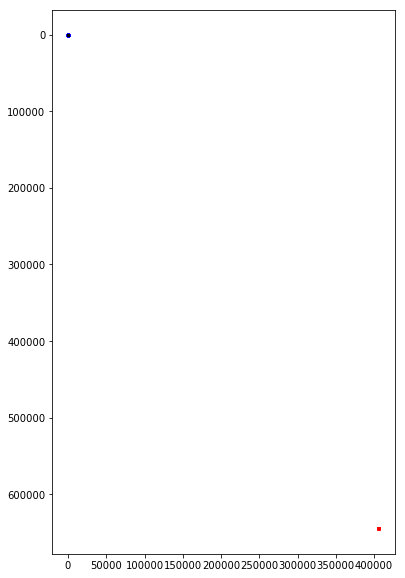

In [123]:
plt.figure(figsize=(10,10))
plt.imshow(np.log10(arr[ymax:ymin,xmin:xmax]),vmin=np.log10(band.GetMinimum()), vmax=np.log10(band.GetMaximum()), cmap='viridis')
#ind=val[0,:] <100 
#ind=[0,1]
#plt.plot(val[1,ind]-xmin,val[2,ind]-ymax, 'go')

ind=outer[:,3]<60
plt.plot(inner[ind,1]-xmin,inner[ind,2]-ymax, 'ro', alpha=0.2,ms=2)
plt.plot(outer[ind,1]-xmin,outer[ind,2]-ymax, 'ko', alpha=0.2,ms=2)
#ind=inner[:,0]>100.0
ind=np.abs(inner[:,0]-outer[:,0])>100
plt.scatter(inner[ind,1]-xmin,inner[ind,2]-ymax, c='b', alpha=0.8,s=6)
plt.plot(points[ind,1],points[ind,2], 'ro', alpha=0.2,ms=2)


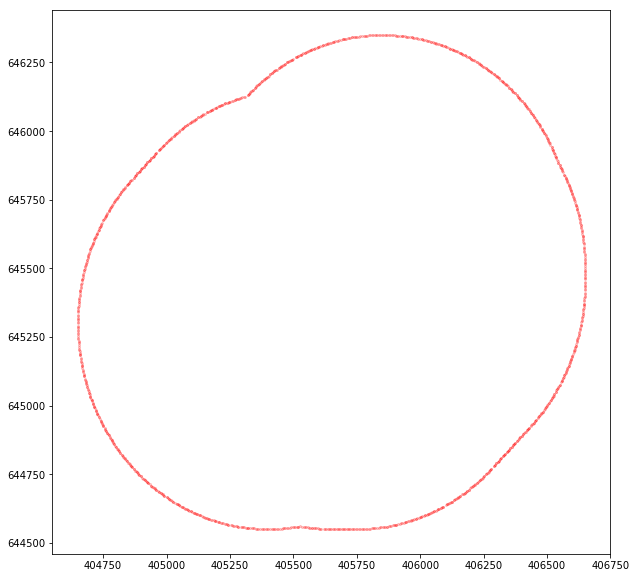

In [126]:
plt.figure(figsize=(10,10))

plt.plot(points[:,1],points[:,2], 'ro', alpha=0.2,ms=2)


In [141]:
ind=points[:,0]>100.0
data = {'Domain': ['NOR_5072_1_Domain.shp'] * ind.sum(),
        'lat': points[ind,2],
        'lon': points[ind,1]}

In [142]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
df = pd.DataFrame(data)

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)

In [143]:
gdf.to_file(filename='./test_table')

## Alternative image based approach

In [339]:
from skimage.filters.rank import gradient
from skimage.morphology import disk

In [344]:
xgrad,ygrad=np.gradient(arr[ymax:ymin,xmin:xmax])

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()


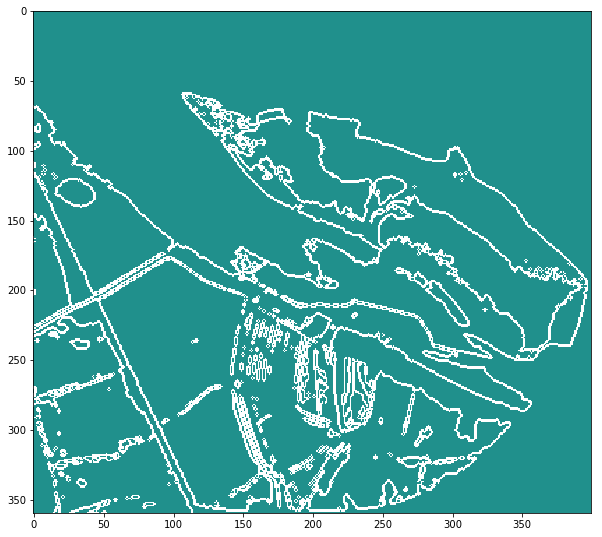

In [355]:

plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(xgrad**2+ygrad**2), vmin=-1000,vmax=1000)

### Rasterise shapefile

In [374]:
import ogr
dataset = ogr.Open('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/NOR_5072_1_Domain.shp')

layer = dataset.GetLayerByIndex(0)


In [366]:
layer.GetExtent()

(404650.00000000186, 406650.0, 644550.0000000037, 646350.0000000037)

In [372]:
layer

In [ ]:
mm.

In [379]:
raster_ds=gdal.Open('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/CombinedOutput_FloodMap/NOR_Fluvial_100yr.tif')
# Fetch number of rows and columns
ncol = raster_ds.RasterXSize
nrow = raster_ds.RasterYSize

# Fetch projection and extent
proj = raster_ds.GetProjectionRef()
ext = raster_ds.GetGeoTransform()

raster_ds = None

# Create the raster dataset
memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create('./test.tiff', ncol, nrow, 1, gdal.GDT_Byte)

# Set the ROI image's projection and extent to our input raster's projection and extent
out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)

# Fill our output band with the 0 blank, no class label, value
b = out_raster_ds.GetRasterBand(1)
b.Fill(0)

# Rasterize the shapefile layer to our new dataset
status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                             [1],  # output to our new dataset's first band
                             layer,  # rasterize this layer
                             None, None,  # don't worry about transformations since we're in same projection
                             [1],  # burn value 0
                             ['ALL_TOUCHED=TRUE']  # rasterize all pixels touched by polygons
                             )


In [380]:
print(out_raster_ds)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x11c31edb0> >


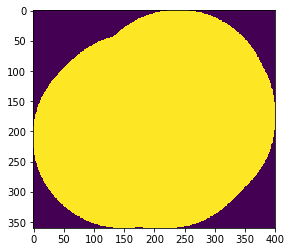

In [384]:
plt.imshow(out_raster_ds.ReadAsArray()[ymax:ymin,xmin:xmax])

In [388]:
from scipy import fftpack

kernel=np.ones((4,4))
kernel_ft = fftpack.fft2(kernel, shape=out_raster_ds.ReadAsArray()[ymax:ymin,xmin:xmax].shape[:2], axes=(0, 1))
kernel_ft.

In [392]:
from scipy import signal

img3 = signal.fftconvolve(out_raster_ds.ReadAsArray()[ymax:ymin,xmin:xmax], kernel_ft, mode='same')

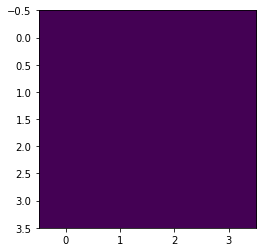

In [400]:
plt.imshow(kernel)

In [405]:
from scipy import ndimage
result = ndimage.uniform_filter(out_raster_ds.ReadAsArray()[ymax:ymin,xmin:xmax], size=-2)

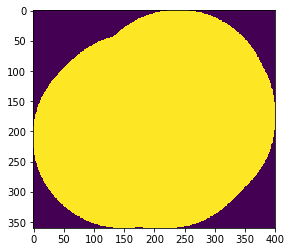

In [406]:
plt.imshow(result)

## Work on combining shapefiles

In [1]:
import ogr
dataset = ogr.Open('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/NOR_5072_1_Domain.shp')

layer = dataset.GetLayerByIndex(0)

In [1]:
import glob
sfiles=glob.glob('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/*.shp')

In [ ]:

# empty geometry
# make the union of polygons
union_poly = ogr.Geometry(ogr.wkbPolygon)

for f in sfiles:
    print(f)
    dataset = ogr.Open(f)
    layer=dataset.GetLayerByIndex(0)
    geom =layer[0].GetGeometryRef()
    union_poly = union_poly.Union(geom)
    dataset=None

In [15]:
layer.

<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x10ee01600> >

<bound method Layer.GetFeature of <osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x10ee013f0> >>

In [ ]:
from osgeo import ogr
test = ogr.Open('polygons.shp')
layer = test.GetLayer()
print layer.GetGeomType()
3 # -> polygons
# empty geometry
union_poly = ogr.Geometry(ogr.wkbPolygon)
# make the union of polygons
for feature in layer:
      geom =feature.GetGeometryRef()
      union_poly = union_poly.Union(geom)

In [4]:
import ogr
shapef = ogr.Open(sfiles[0])
lyr = shapef.GetLayer()
unionc = ogr.Geometry(ogr.wkbMultiPolygon)
for feat in range(lyr.GetFeatureCount()):
    fit= lyr.GetFeature(feat)
    geom= fit.GetGeometryRef()
    unionc.AddGeometry(geom)
union= unionc.UnionCascaded()

In [77]:
import glob
import shapefile
files = glob.glob('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/*.shp')
w = shapefile.Writer()
for f in files:
    r = shapefile.Reader(f)
    w._shapes.extend(r.shapes())
    w.records.extend(r.records())
w.fields = list(r.fields)
w.save("merged")

In [90]:
from osgeo import ogr
shapef=ogr.Open('./merged.shp')

In [91]:
sh_points=np.array(sf.shapes()[0].points)

In [148]:
w.fields

[['Buffer', 'C', 80, 0], ['Cellmap', 'C', 80, 0]]

## Point in Shapefile?

In [175]:
import shapefile
from shapely.geometry import Point # Point class
from shapely.geometry import shape # shape() is a function to convert geo objects through the interface

point = (1234,5678) # an x,y tuple
shp = shapefile.Reader('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/NOR_5072_1_Domain.shp') #open the shapefile
all_shapes = shp.shapes() # get all the polygons
all_records = shp.records()
for i in len(all_shapes):
    boundary = all_shapes[i] # get a boundary polygon
    if Point(pt).within(shape(boundary)): # make a point and see if it's in the polygon
        name = all_records[i][2] # get the second field of the corresponding record
        print('The point is in', name)

TypeError: 'int' object is not iterable

In [195]:
point = (405000,645000)
boundary = all_shapes[0]
Point(point).within(shape(boundary))

True

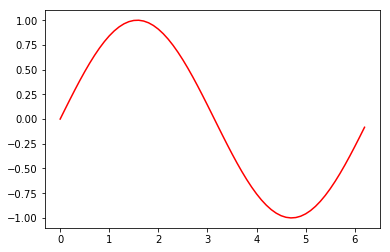

In [60]:
plt.plot(np.arange(0,2*np.pi, 0.1),np.sin(np.arange(0,2*np.pi, 0.1)),'r-')

In [58]:
np.arctan(1000.0)

1.5697963271282298